<a href="https://colab.research.google.com/github/Tensor-Reloaded/IOAI-Workshop-CV-1/blob/main/multitask/1.multitask-intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multitask intro

Multitask learning is a technique in which a single model learns to perform multiple related tasks at the same time.

Multitasking involves learning shared representations that can be used for multiple tasks. This is usually done by having a "backbone" (usually an encoder-type model) and multiple task-specific heads (decoder-type models or simple MLPs).
Each task-specific head is trained separately using a task-specific loss, and the loss also propagates to the backbone.

Advantages:
* the backbone learns to extract better features from the input
* multitask learning is more efficient than training multiple models
* may lead to better generalization (similar to transfer learning)
* reduces overfitting due to the shared representations

### Pareto Front

In multitask learning, training on multiple tasks can introduce trade-offs. The **Pareto front** represents the set of optimal trade-offs where no task can be improved without hurting at least one other.

Understanding and approaching the Pareto front is important because:

* it helps identify the best balance between competing objectives
* it highlights inherent task conflicts
* it encourages more robust evaluation across tasks
* it supports informed decision-making when prioritizing task performance



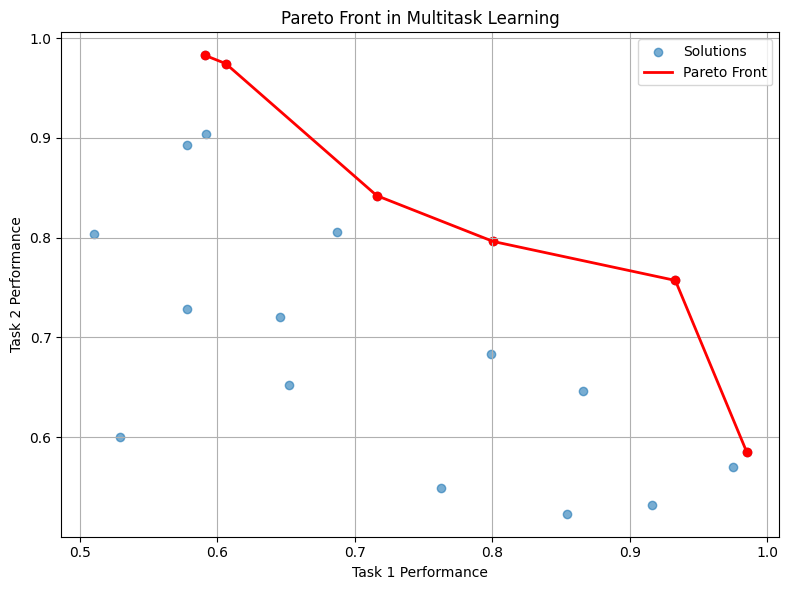

In [ ]:
import torch

from torch import nn, Tensor
from typing import List
from tqdm.auto import trange, tqdm
from torchvision import datasets
from torchvision.transforms import v2

In [ ]:
# Here we have a generic multi task model
# The backbone learns the shared representation

class GenericMultitaskModel(nn.Module):
    def __init__(self, backbone: nn.Module, task_heads: List[nn.Module]):
        super().__init__()
        self.backbone = backbone
        self.task_heads = nn.ModuleList(task_heads)

    def forward(self, x: Tensor) -> List[Tensor]:
        # backbone: input_space -> latent_shared_representation_space
        # The backbone learns a function that transforms input data to a shared representation space with usefull features that can be used by multiple tasks
        shared_representation = self.backbone(x)
        task_outputs = []
        for task_head in self.task_heads:
            # task_output: latent_shared_representation_space -> task_output
            task_output = task_head(shared_representation)
            task_outputs.append(task_output)
        return task_outputs

Now we can define a backbone and multiple task heads, and create a multitask model.

We can train the multitask model similar to standard models. We just have to be aware that we have multiple model outputs, one for each task.

Therefore, we have to calculate a loss function between the ground truth and the prediction for each task. Then, we aggregate the per-task losses, and backpropagate the resul.

## Multitask on MNIST

Task 1: classify images into digits from 0 to 9

Task 2: classify images into even and odd

In [ ]:
class ParityMNIST(torch.utils.data.Dataset):
    def __init__(self, train):
        self.dataset = datasets.MNIST(root="../data", train=train, download=True)
        self.transforms = v2.Compose(
            [
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize([0.1307], [0.3081], inplace=True),
                torch.flatten,
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        image, label = self.dataset[i]
        return {
            "data": self.transforms(image),
            "digit_label": label,
            "parity_label": 0 if label % 2 == 0 else 1,
        }

In [ ]:
backbone = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
)
digit_task = nn.Sequential(
    nn.Linear(100, 10),
)
parity_task = nn.Sequential(
    nn.Linear(100, 2),
)
model = GenericMultitaskModel(backbone=backbone, task_heads=[digit_task, parity_task])

In [ ]:
dataset = ParityMNIST(train=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss()  # Here criterion_2 is the same as criterion_1. But we can also use different loss functions.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 9.91M/9.91M [00:18<00:00, 542kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 218kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 529kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


**Excercise 1**: Write the training loop and check that each task loss is decreasing!

In [ ]:
def train(model, dataloader, optimizer, criterion_1, criterion_2, iterations):
    model.train()
    for i, batch in enumerate(dataloader):
        if i >= iterations:
            break

        data = batch["data"]
        task_1_labels = batch["digit_label"]
        task_2_labels = batch["parity_label"]

        # Complete the code!
        loss1 = ...
        loss2 = ...

        print("Task 1 loss", loss1.item())
        print("Task 2 loss", loss2.item())
        print()

        # Aggregate the two losses and backpropagate them!

        optimizer.step()
        optimizer.zero_grad()


In [ ]:
train(model, dataloader, optimizer, criterion_1, criterion_2, 6)

Task 1 loss 2.3781790733337402
Task 2 loss 0.717403769493103

Task 1 loss 2.225315570831299
Task 2 loss 0.6634694933891296

Task 1 loss 2.139712333679199
Task 2 loss 0.6054487824440002

Task 1 loss 2.0010242462158203
Task 2 loss 0.5551760792732239

Task 1 loss 1.9586268663406372
Task 2 loss 0.5273295640945435

Task 1 loss 1.953698992729187
Task 2 loss 0.5613130927085876



You should see something like this:
```
Task 1 loss 2.3236191272735596
Task 2 loss 0.732703447341919

Task 1 loss 2.310081720352173
Task 2 loss 0.7832657098770142

Task 1 loss 2.303960084915161
Task 2 loss 0.7539554238319397

Task 1 loss 2.2776031494140625
Task 2 loss 0.6621295213699341

Task 1 loss 2.299744129180908
Task 2 loss 0.7180918455123901

Task 1 loss 2.327526092529297
Task 2 loss 0.6933788061141968

Task 1 loss 2.2679240703582764
Task 2 loss 0.6990024447441101
```

<details>
<summary>Answer</summary>
<br>
<pre>
def train(model, dataloader, optimizer, criterion_1, criterion_2, iterations):
    model.train()
    for i, batch in enumerate(dataloader):
        if i >= iterations:
            break
        data = batch["data"]
        task_1_labels = batch["digit_label"]
        task_2_labels = batch["parity_label"]
        task_outputs = model(data)
        loss1 = criterion_1(task_outputs[0], task_1_labels)
        loss2 = criterion_2(task_outputs[1], task_2_labels)
        loss = loss1 + loss2
        loss.backward()
        print("Task 1 loss", loss1.item())
        print("Task 2 loss", loss2.item())
        print()
        optimizer.step()
        optimizer.zero_grad()
</pre>
</details>

We can see that the losses are decreasing, so the model is learning both tasks.

However, the first loss is decreasing faster, while the 2nd is decreasing slower. Why?

In [ ]:
loss1 = ...
loss2 = ...
# Not all tasks are equal!
# If we sum multiple losses, the larger loss dominates the training, biasing the model towards that task
# Sometimes, one task is more important, so we can give that task more weight
# Sometimes, one task is easier than the other, so the model learns it faster. We need to scale down that loss to prevent overfit
factor1 = ...
factor2 = ...
loss = factor1 * loss1 + factor2 * loss2

Let's apply what we learned and train a multitask model on MNIST. We will use a trainer and vary the parameters in order to obtain better results.

In [ ]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        batch_size = 128,
        val_batch_size = 500,
        factor_1 = 1.0,
        factor_2 = 0.5,

    ):
        self.model = model
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.val_batch_size = val_batch_size
        self.factor_1 = factor_1
        self.factor_2 = factor_2

        self.device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
        print("Using device", self.device)
        self.train_loader = torch.utils.data.DataLoader(ParityMNIST(train=True), shuffle=True, batch_size=self.batch_size, drop_last=True)
        self.val_loader = torch.utils.data.DataLoader(ParityMNIST(train=False), batch_size=self.val_batch_size)
        self.criterion_1 = nn.CrossEntropyLoss()
        self.criterion_2 = nn.CrossEntropyLoss()

        self.model = self.model.to(self.device)

    def train(self):
        self.model.train()

        correct_digits = 0
        correct_parity = 0
        total = 0
        total_loss = 0

        for batch in tqdm(self.train_loader, leave=False):
            data = batch["data"].to(self.device)
            digit_labels = batch["digit_label"].to(self.device)
            parity_labels = batch["parity_label"].to(self.device)
            digit_predicted, parity_predicted = self.model(data)
            loss_1 = self.criterion_1(digit_predicted, digit_labels) * self.factor_1
            loss_2 = self.criterion_2(parity_predicted, parity_labels) * self.factor_2
            loss = loss_1 + loss_2
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            correct_digits += digit_predicted.argmax(1).eq(digit_labels).sum().item()
            correct_parity += parity_predicted.argmax(1).eq(parity_labels).sum().item()
            total += digit_labels.size(0)
            total_loss += loss.item()

        return 100.0 * correct_digits / total, 100.0 * correct_parity / total, total_loss / len(self.train_loader)

    # @torch.no_grad()
    @torch.inference_mode()
    def val(self):
        self.model.eval()

        correct_digits = 0
        correct_parity = 0
        total = 0
        total_loss = 0

        for batch in tqdm(self.val_loader, leave=False):
            data = batch["data"].to(self.device)
            digit_labels = batch["digit_label"].to(self.device)
            parity_labels = batch["parity_label"].to(self.device)
            digit_predicted, parity_predicted = self.model(data)
            loss_1 = self.criterion_1(digit_predicted, digit_labels) * self.factor_1
            loss_2 = self.criterion_2(parity_predicted, parity_labels) * self.factor_2
            loss = loss_1 + loss_2

            correct_digits += digit_predicted.argmax(1).eq(digit_labels).sum().item()
            correct_parity += parity_predicted.argmax(1).eq(parity_labels).sum().item()
            total += digit_labels.size(0)
            total_loss += loss.item()

        return 100.0 * correct_digits / total, 100.0 * correct_parity / total, total_loss / len(self.val_loader)

    def run(self, epochs):
        with trange(epochs) as tbar:
            for _ in tbar:
                train_digits_acc, train_parity_acc, train_loss = self.train()
                val_digits_acc, val_parity_acc, val_loss = self.val()
                tbar.set_description(f"Train: {train_digits_acc:.1f}, {train_parity_acc:.1f}, {train_loss:.3f}, "
                                     f"Val: {val_digits_acc:.1f}, {val_parity_acc:.1f}, {val_loss:.3f}")

In [ ]:
model = GenericMultitaskModel(
    backbone=nn.Sequential(
        nn.Linear(784, 100),
        nn.ReLU(),
    ),
    task_heads=[
        nn.Sequential(nn.Linear(100, 10)), nn.Sequential(nn.Linear(100, 2))
    ]
)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
Trainer(model, optimizer).run(10)

**Excercise 2**. Use the multitask_mnist.py script or this notebook to train a multitask network. What parameters can achieve better results?